In [ ]:
!python -m pip install hypertab==0.1.5

# HyperTab Ablation Study
In this notebook we're going to recreate ablation study from the publication. Namely - let's check what happens if our dataset contains few informative features.

In [2]:
from hypertab import HyperTabClassifier

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

import numpy as np
import imblearn
import pandas as pd
import torch
import seaborn as sns

In [40]:
# HyperTab is pretty slow, so we need to boost it using GPU
DEVICE = "cuda:0"

## Prepare the data
We are going to create a ridiculously small dataset - 5 classes and 50 samples. The dataset is going to have 50 columns, but 49 of them are going to be noise. Only one will be informative.

We are going to test how well XGBoost and HyperTab does in scenario like this, and then we're going to analyze the reason for HyperTab's performance

In [57]:
y = np.random.randint(0, 5, 50)
X = np.random.random((50, 50))
X[:, 0] = y

max_size = int(len(X)*0.7)
print(f"Full dataset size: {X.shape}. Training size: {max_size}")
n_classes = len(np.unique(y))

Full dataset size: (50, 50). Training size: 35


In [58]:
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size, stratify=y)
    X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prepare_data(X, y)

## Check HyperTab performance

In [59]:
def get_hypernetwork():
    return HyperTabClassifier(0.2, device=DEVICE, test_nodes=250, epochs=10, hidden_dims=5)

In [60]:
%%time

hypertab = get_hypernetwork()
hypertab.fit(X_train, y_train)
y_pred = hypertab.predict(X_test)

bacc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {bacc*100:.2f}%\n")

Balanced accuracy: 100.00%

CPU times: user 6.71 s, sys: 563 ms, total: 7.28 s
Wall time: 7.62 s


## Ablation analysis

### How many test nodes use the only informative feature?

In [61]:
print(f"{hypertab.interface.network.test_mask[:, 0].sum()/len(hypertab.interface.network.test_mask)*100:.0f}%")

17%


### What is the voting distribution among them?

In [69]:
X_test_torch = torch.from_numpy(X_test).to(DEVICE).to(torch.float)

using_info = hypertab.interface.network.test_mask[:, 0].to(bool)
masks = hypertab.interface.network.test_mask[using_info].to(torch.float)
votes_informative = hypertab.interface.network(X_test_torch, masks)

using_info = ~hypertab.interface.network.test_mask[:, 0].to(bool)
masks = hypertab.interface.network.test_mask[using_info]
votes_uninformative = hypertab.interface.network(X_test_torch, masks)

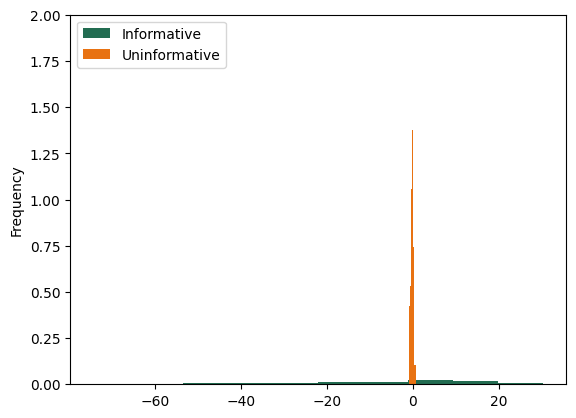

In [68]:
import matplotlib.pyplot as plt

plt.style.use("default")
ax = plt.gca()
pd.DataFrame(votes_informative.ravel().detach().cpu()).plot(kind="hist", ax=ax, density=True, color="#226c51")
pd.DataFrame(votes_uninformative.ravel().detach().cpu()).plot(kind="hist", ax=ax, density=True, color="#e87212")
plt.legend(["Informative", "Uninformative"]);